# Задача 4, Ансамбли.

Автор: Полынцов Михаил, 23.М04-мм.

- [✔] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [✔] Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
- [✔] Самостоятельно реализуйте алгоритмы Bagging и AdaBoost, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [✔] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из sklearn (Bagging, Random Forest, AdaBoost, Gradient Tree Boosting, Histogram-Based Gradient Boosting).
- [✔] При обучении использовать подбор гиперпараметров, кросс-валидацию.
- [✔] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [✔] (+2 балла) Также добавить в сравнение модели из библиотек XGBoost, LightGBM и CatBoost.
- [✔] (+3 балла) Для подбора гиперпараметров использовать фреймворк Optuna.

In [114]:
# Скачаем датасет: https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction
#!kaggle datasets download -d kelvinkelue/credit-card-fraud-prediction
#!unzip "credit-card-fraud-prediction.zip"

In [143]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_X_y, check_array, check_random_state, check_scalar
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import check_X_y, check_array, check_random_state, check_scalar
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import time

In [116]:
df = pd.read_csv("fraud test.csv")
df.columns.values

array(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant',
       'category', 'amt', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype=object)

## Описание атрибутов датасета
- Trans_date_trans_time: Timestamp of the transaction (date and time).
- Cc_num: Unique customer identification number.
- Merchant: The merchant involved in the transaction.
- Category: Transaction type (e.g., personal, childcare).
- Amt: Transaction amount.
- First: Cardholder's first name.
- Last Cardholder's last name.
- Gender: Cardholder's gender.
- Street: Cardholder's street address.
- City: Cardholder's city of residence.
- State: Cardholder's state of residence.
- Zip: Cardholder's zip code.
- Lat: Latitude of cardholder's location.
- Long: Longitude of cardholder's location.
- City_pop: Population of the cardholder's city.
- Job: Cardholder's job title.
- Dob: Cardholder's date of birth.
- Trans_num: Unique transaction identifier.
- Unix_time: Transaction timestamp (Unix format).
- Merch_lat: Merchant's location (latitude).
- Merch_long: Merchant's location (longitude).
- Is_fraud: Fraudulent transaction indicator (1 = fraud, 0 = legitimate). This is the target variable for classification purposes. -- целевой признак

In [117]:
df.drop(columns=["Unnamed: 0"], inplace=True)
# В датасете нет пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  float64
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [118]:
# Имя и фамилия держателя карты не нужны, потому что уже есть идентификационный номер cc_num
df.drop(columns=['first', 'last'], inplace=True)

print(f"cc_num: {df['cc_num'].nunique()}") # 904 различных айди держателя карты
print(f"street: {df['street'].nunique()}") # 924 различных адреса
print(f"city: {df['city'].nunique()}") # 849 различных города
print(f"state: {df['state'].nunique()}") # 50 различных штатов
print(f"merchant: {df['merchant'].nunique()}") # 693 различных получателя
print(f"job: {df['job'].nunique()}")

# закодировать эту информацию не сможем и скорее всего она окажется излишней, потому что имя практически всегда определяется идентификаторов держателя,
# адрес zip-кодом, а получатель через координаты merch_lat и merch_long => убираем эти колонки
df.drop(columns=['cc_num', 'street', 'city', 'state', 'merchant', 'job'], inplace=True)

cc_num: 904
street: 924
city: 849
state: 50
merchant: 693
job: 478


In [119]:
print(df['trans_date_trans_time'])

# Дата транзакции в таком виде не нужна, потому что уже есть unix_time
df.drop(columns='trans_date_trans_time', inplace=True)

0         21/06/2020 12:14
1         21/06/2020 12:14
2         21/06/2020 12:14
3         21/06/2020 12:15
4         21/06/2020 12:15
                ...       
555714    31/12/2020 23:59
555715    31/12/2020 23:59
555716    31/12/2020 23:59
555717    31/12/2020 23:59
555718    31/12/2020 23:59
Name: trans_date_trans_time, Length: 555719, dtype: object


In [120]:
print(df['category'].value_counts()) # категориальное значение

# закодируем категорию с помощью onehotencoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[['category']])
new_feature_names = encoder.get_feature_names_out(['category'])
df = pd.concat([df.drop('category', axis=1), pd.DataFrame(encoded_data, columns=new_feature_names)], axis=1)
print(df.info())

category
gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel            17449
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   amt                      555719 non-null  float64
 1   gender                   555719 non-null  object 
 2   zip                      555719 non-null  int64  
 3   lat                      555719 non-null  float64
 4   long                     555719 non-null  float64
 5   city_pop                 555719 non-null  int64  
 6   dob                      555719 non-null  object 
 7   trans_num                555719 non-null  object 
 8   unix_time                555719 non-null  int64  
 9   merch_lat                555719 non-null  float64
 10  merch_long               555719 non-null  float64
 11  is_fraud                 555719 non-null  int64  
 12  category_food_dining     555719 non-null  float64
 13  category_gas_transport   555719 non-null  float64
 14  cate

In [121]:
print(df['dob'])

# Сконвертируем дату рождения в возраст
# Convert the 'dob' column to datetime objects
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')
df['age'] = 2020 - df['dob'].dt.year # потому что посчитать честное количество лет удивительно сложно через pandas
df.drop(columns=['dob'], inplace=True)
print(df['age'].value_counts())


0         19/03/1968
1         17/01/1990
2         21/10/1970
3         25/07/1987
4         06/07/1955
             ...    
555714    13/02/1966
555715    27/12/1999
555716    29/11/1981
555717    15/12/1965
555718    10/05/1993
Name: dob, Length: 555719, dtype: object
age
48    19553
36    16926
35    16022
33    15896
46    14685
      ...  
73     1307
15      963
88      869
96      199
18       12
Name: count, Length: 81, dtype: int64


In [122]:
# Закодируем пол числовым значением
df['gender'] = df['gender'].replace({'M': 1, 'F': 0})

/tmp/ipykernel_30087/2014994539.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'M': 1, 'F': 0})


In [123]:
print(df['trans_num'].describe()) # не похоже, что айди что-то означает и может нам понадобиться
df.drop(columns=['trans_num'], inplace=True)

count                               555719
unique                              555719
top       2da90c7d74bd46a0caf3777415b3ebd3
freq                                     1
Name: trans_num, dtype: object


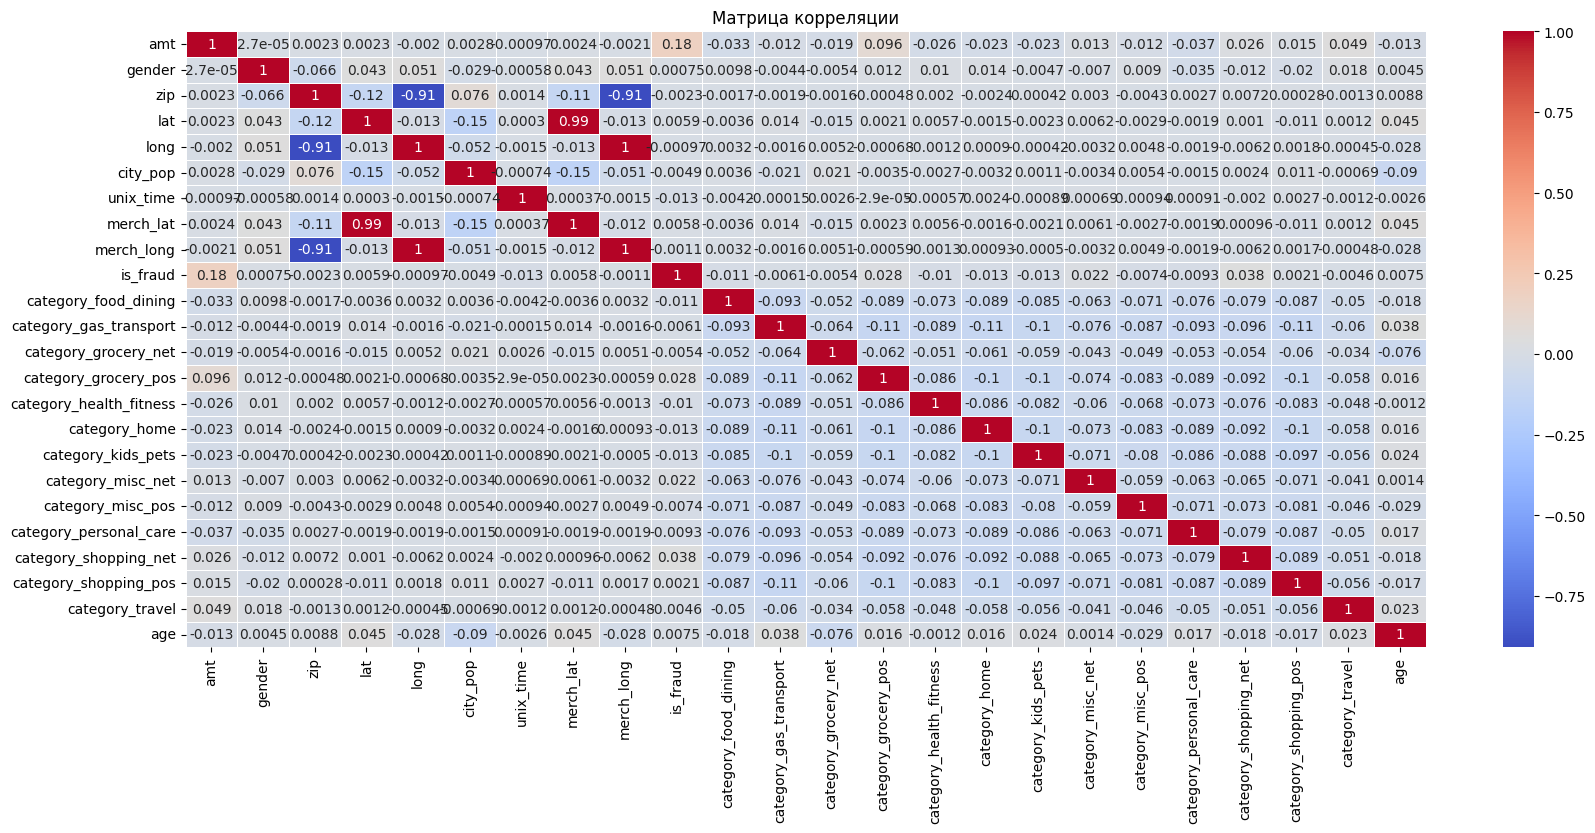

In [124]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

In [125]:
# У long и march_long, lat и match_lat очень высокая корреляция (видимо транзации происходят между картами, находящимися физически близко), удалим lat и long как шум
df.drop(columns=['long', 'lat'], inplace=True)

## Реализация алгоритма Bagging 

In [126]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator if estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, ensure_2d=True, dtype=None)
        
        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
        
        self.estimators_ = [self._fit_base_estimator(X, y) for _ in range(self.n_estimators)]
        return self

    def _fit_base_estimator(self, X, y):
        sample_indices = self.random_state_.choice(len(y), size=len(y), replace=True)
        X_sample, y_sample = X[sample_indices], y[sample_indices]
        
        estimator = clone(self.estimator)
        estimator.fit(X_sample, y_sample)
        return estimator

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x, minlength=len(self.classes_)).argmax(), axis=0, arr=predictions)
        return self.classes_[majority_votes]

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        probas = np.mean([estimator.predict_proba(X) for estimator in self.estimators_], axis=0)
        return probas

## Реавлизация алгоритма AdaBoost

In [127]:
class CustomAdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, n_estimators=50, random_state=None):
        self.base_classifier = base_classifier or DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.classifiers = []

        self.regularization = 1e-4

    def _initialize_params(self, n_samples):
        self.weights = np.full(n_samples, 1.0 / n_samples)
        self.classifier_weights = np.zeros(self.n_estimators)

    def _update_weights(self, y_true, predictions, total_error, i):
        classifier_weight = 0.5 * np.log((1 - total_error) / (total_error + self.regularization))
        self.classifier_weights[i] = classifier_weight

        correct_mask = y_true == predictions
        self.weights[correct_mask] *= np.exp(classifier_weight)
        self.weights[~correct_mask] *= np.exp(-classifier_weight)
        self.weights /= np.sum(self.weights)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self._initialize_params(len(X))

        for i in range(self.n_estimators):
            classifier = self.base_classifier.__class__()
            classifier.fit(X, y)
            predictions = classifier.predict(X)
            
            total_error = np.sum(self.weights[predictions != y])
            
            self._update_weights(y, predictions, total_error, i)
            self.classifiers.append(classifier)

    def predict(self, X):
        num_samples = X.shape[0]
        weighted_sum_predictions = np.zeros((num_samples, self.n_classes_))
        
        for classifier, weight in zip(self.classifiers, self.classifier_weights):
            predictions = classifier.predict(X)
            for class_index in range(self.n_classes_):
                class_mask = predictions == self.classes_[class_index]
                weighted_sum_predictions[np.arange(num_samples)[class_mask], class_index] += weight
        
        return self.classes_[np.argmax(weighted_sum_predictions, axis=1)]

## Обучение моделей, подбор гиперпараметров

In [128]:
y = df['is_fraud']
X = df.drop('is_fraud', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [142]:
y.value_counts()
print(y_test.value_counts())

is_fraud
0    138401
1       529
Name: count, dtype: int64


In [134]:
model_search_spaces = {
    'CustomBaggingClassifier': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 5, 16)},
    'CustomAdaBoostClassifier': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 10, 50, step=10)},
    'BaggingClassifier': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 5, 15)},
    'RandomForestClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 10, 20),
            'max_depth': trial.suggest_int('max_depth', 5, 20)
        },
    'AdaBoostClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 5, 15),
        },
    'GradientBoostingClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 10, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        },
    'HistGradientBoostingClassifier': lambda trial: {
            'max_iter': trial.suggest_int('max_iter', 10, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        },
    'XGBClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 10, 20)
        },
    'LGBMClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 10, 20)
        },
    'CatBoostClassifier': lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 10, 20)
        }
}

def create_model(model_name, model_params):
    match model_name:
        case 'CustomBaggingClassifier':
            model = CustomBaggingClassifier(**model_params)
        case 'CustomAdaBoostClassifier':
            model = CustomAdaBoostClassifier(**model_params)
        case 'BaggingClassifier':
            model = BaggingClassifier(**model_params)
        case 'RandomForestClassifier':
            model = RandomForestClassifier(**model_params)
        case 'AdaBoostClassifier':
            model = AdaBoostClassifier(**model_params)
        case 'GradientBoostingClassifier':
            model = GradientBoostingClassifier(**model_params)
        case 'HistGradientBoostingClassifier':
            model = HistGradientBoostingClassifier(**model_params)
        case 'XGBClassifier':
            model = XGBClassifier(**model_params)
        case 'LGBMClassifier':
            model = LGBMClassifier(**model_params)
        case 'CatBoostClassifier':
            model = CatBoostClassifier(**model_params)
        case _:
            raise RuntimeError("Unknown model name")
    return model
 
def objective(trial, model_name):
    model_params = model_search_spaces[model_name](trial)
    model_params['random_state'] = 111
    
    model = create_model(model_name, model_params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=6).mean()
    return f1

In [135]:
results = [('CustomAdaBoostClassifier', 0.6285412940397854, {'n_estimators': 20}, 907.4096632003784), ('CustomBaggingClassifier', 0.7025266495773105, {'n_estimators': 11}, 300.8159854412079), ('BaggingClassifier', 0.7094395370205568, {'n_estimators': 12}, 213.9601287841797), ('RandomForestClassifier', 0.6783981821852841, {'n_estimators': 13, 'max_depth': 20}, 65.9663622379303), ('AdaBoostClassifier', 0.24035238436936912, {'n_estimators': 51}, 202.7789273262024), ('GradientBoostingClassifier', 0.5900221854190122, {'n_estimators': 20, 'learning_rate': 0.08875489468935226}, 130.9240961074829), ('HistGradientBoostingClassifier', 0.6024727758485022, {'max_iter': 11, 'learning_rate': 0.05770228334724648}, 11.102336645126343), ('XGBClassifier', 0.637505098877247, {'n_estimators': 19}, 7.011621713638306), ('LGBMClassifier', 0.5534735426719214, {'n_estimators': 13}, 297.2201361656189), ('CatBoostClassifier', 0.6486125601940748, {'n_estimators': 20}, 14.07069706916809)]
best_params = {'CustomAdaBoostClassifier': {'n_estimators': 20}, 'CustomBaggingClassifier': {'n_estimators': 11}, 'BaggingClassifier': {'n_estimators': 12}, 'RandomForestClassifier': {'n_estimators': 13, 'max_depth': 20}, 'AdaBoostClassifier': {'n_estimators': 51}, 'GradientBoostingClassifier': {'n_estimators': 20, 'learning_rate': 0.08875489468935226}, 'HistGradientBoostingClassifier': {'max_iter': 11, 'learning_rate': 0.05770228334724648}, 'XGBClassifier': {'n_estimators': 19}, 'LGBMClassifier': {'n_estimators': 13}, 'CatBoostClassifier': {'n_estimators': 20}}

for model_name in model_search_spaces.keys():
    if model_name in best_params.keys(): continue
    print(f"Optimizing {model_name}...")

    start_time = time.time()

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name), n_trials=10, n_jobs=10)

    end_time = time.time()
    elapsed_time = end_time - start_time

    best_params[model_name] = study.best_params

    results.append((model_name, study.best_trial.value, study.best_params, elapsed_time))

In [136]:
print(results)
print(best_params)

[('CustomAdaBoostClassifier', 0.6285412940397854, {'n_estimators': 20}, 907.4096632003784), ('CustomBaggingClassifier', 0.7025266495773105, {'n_estimators': 11}, 300.8159854412079), ('BaggingClassifier', 0.7094395370205568, {'n_estimators': 12}, 213.9601287841797), ('RandomForestClassifier', 0.6783981821852841, {'n_estimators': 13, 'max_depth': 20}, 65.9663622379303), ('AdaBoostClassifier', 0.24035238436936912, {'n_estimators': 51}, 202.7789273262024), ('GradientBoostingClassifier', 0.5900221854190122, {'n_estimators': 20, 'learning_rate': 0.08875489468935226}, 130.9240961074829), ('HistGradientBoostingClassifier', 0.6024727758485022, {'max_iter': 11, 'learning_rate': 0.05770228334724648}, 11.102336645126343), ('XGBClassifier', 0.637505098877247, {'n_estimators': 19}, 7.011621713638306), ('LGBMClassifier', 0.5534735426719214, {'n_estimators': 13}, 297.2201361656189), ('CatBoostClassifier', 0.6486125601940748, {'n_estimators': 20}, 14.07069706916809)]
{'CustomAdaBoostClassifier': {'n_es

/home/arno/prog/spbu/ml-course/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1616, number of negative: 415173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 416789, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003877 -> initscore=-5.548741
[LightGBM] [Info] Start training from score -5.548741
Learning rate set to 0.5
0:	learn: 0.0551706	total: 30.7ms	remaining: 583ms
1:	learn: 0.0177153	total: 47.2ms	remaining: 425ms
2:	learn: 0.0141035	total: 62ms	remaining: 351ms
3:	learn: 0.0115452	total: 76.3ms	remaining: 305ms
4:	learn: 0.0110725	total: 90.2ms	remaining: 271ms
5:	learn: 0.0100607	total: 104ms	remaining: 242ms
6:	learn: 0.0097631	total: 118ms	remaining: 220ms
7:	learn: 0.0094192	total: 133ms	remaining: 200ms
8:	learn: 0.0

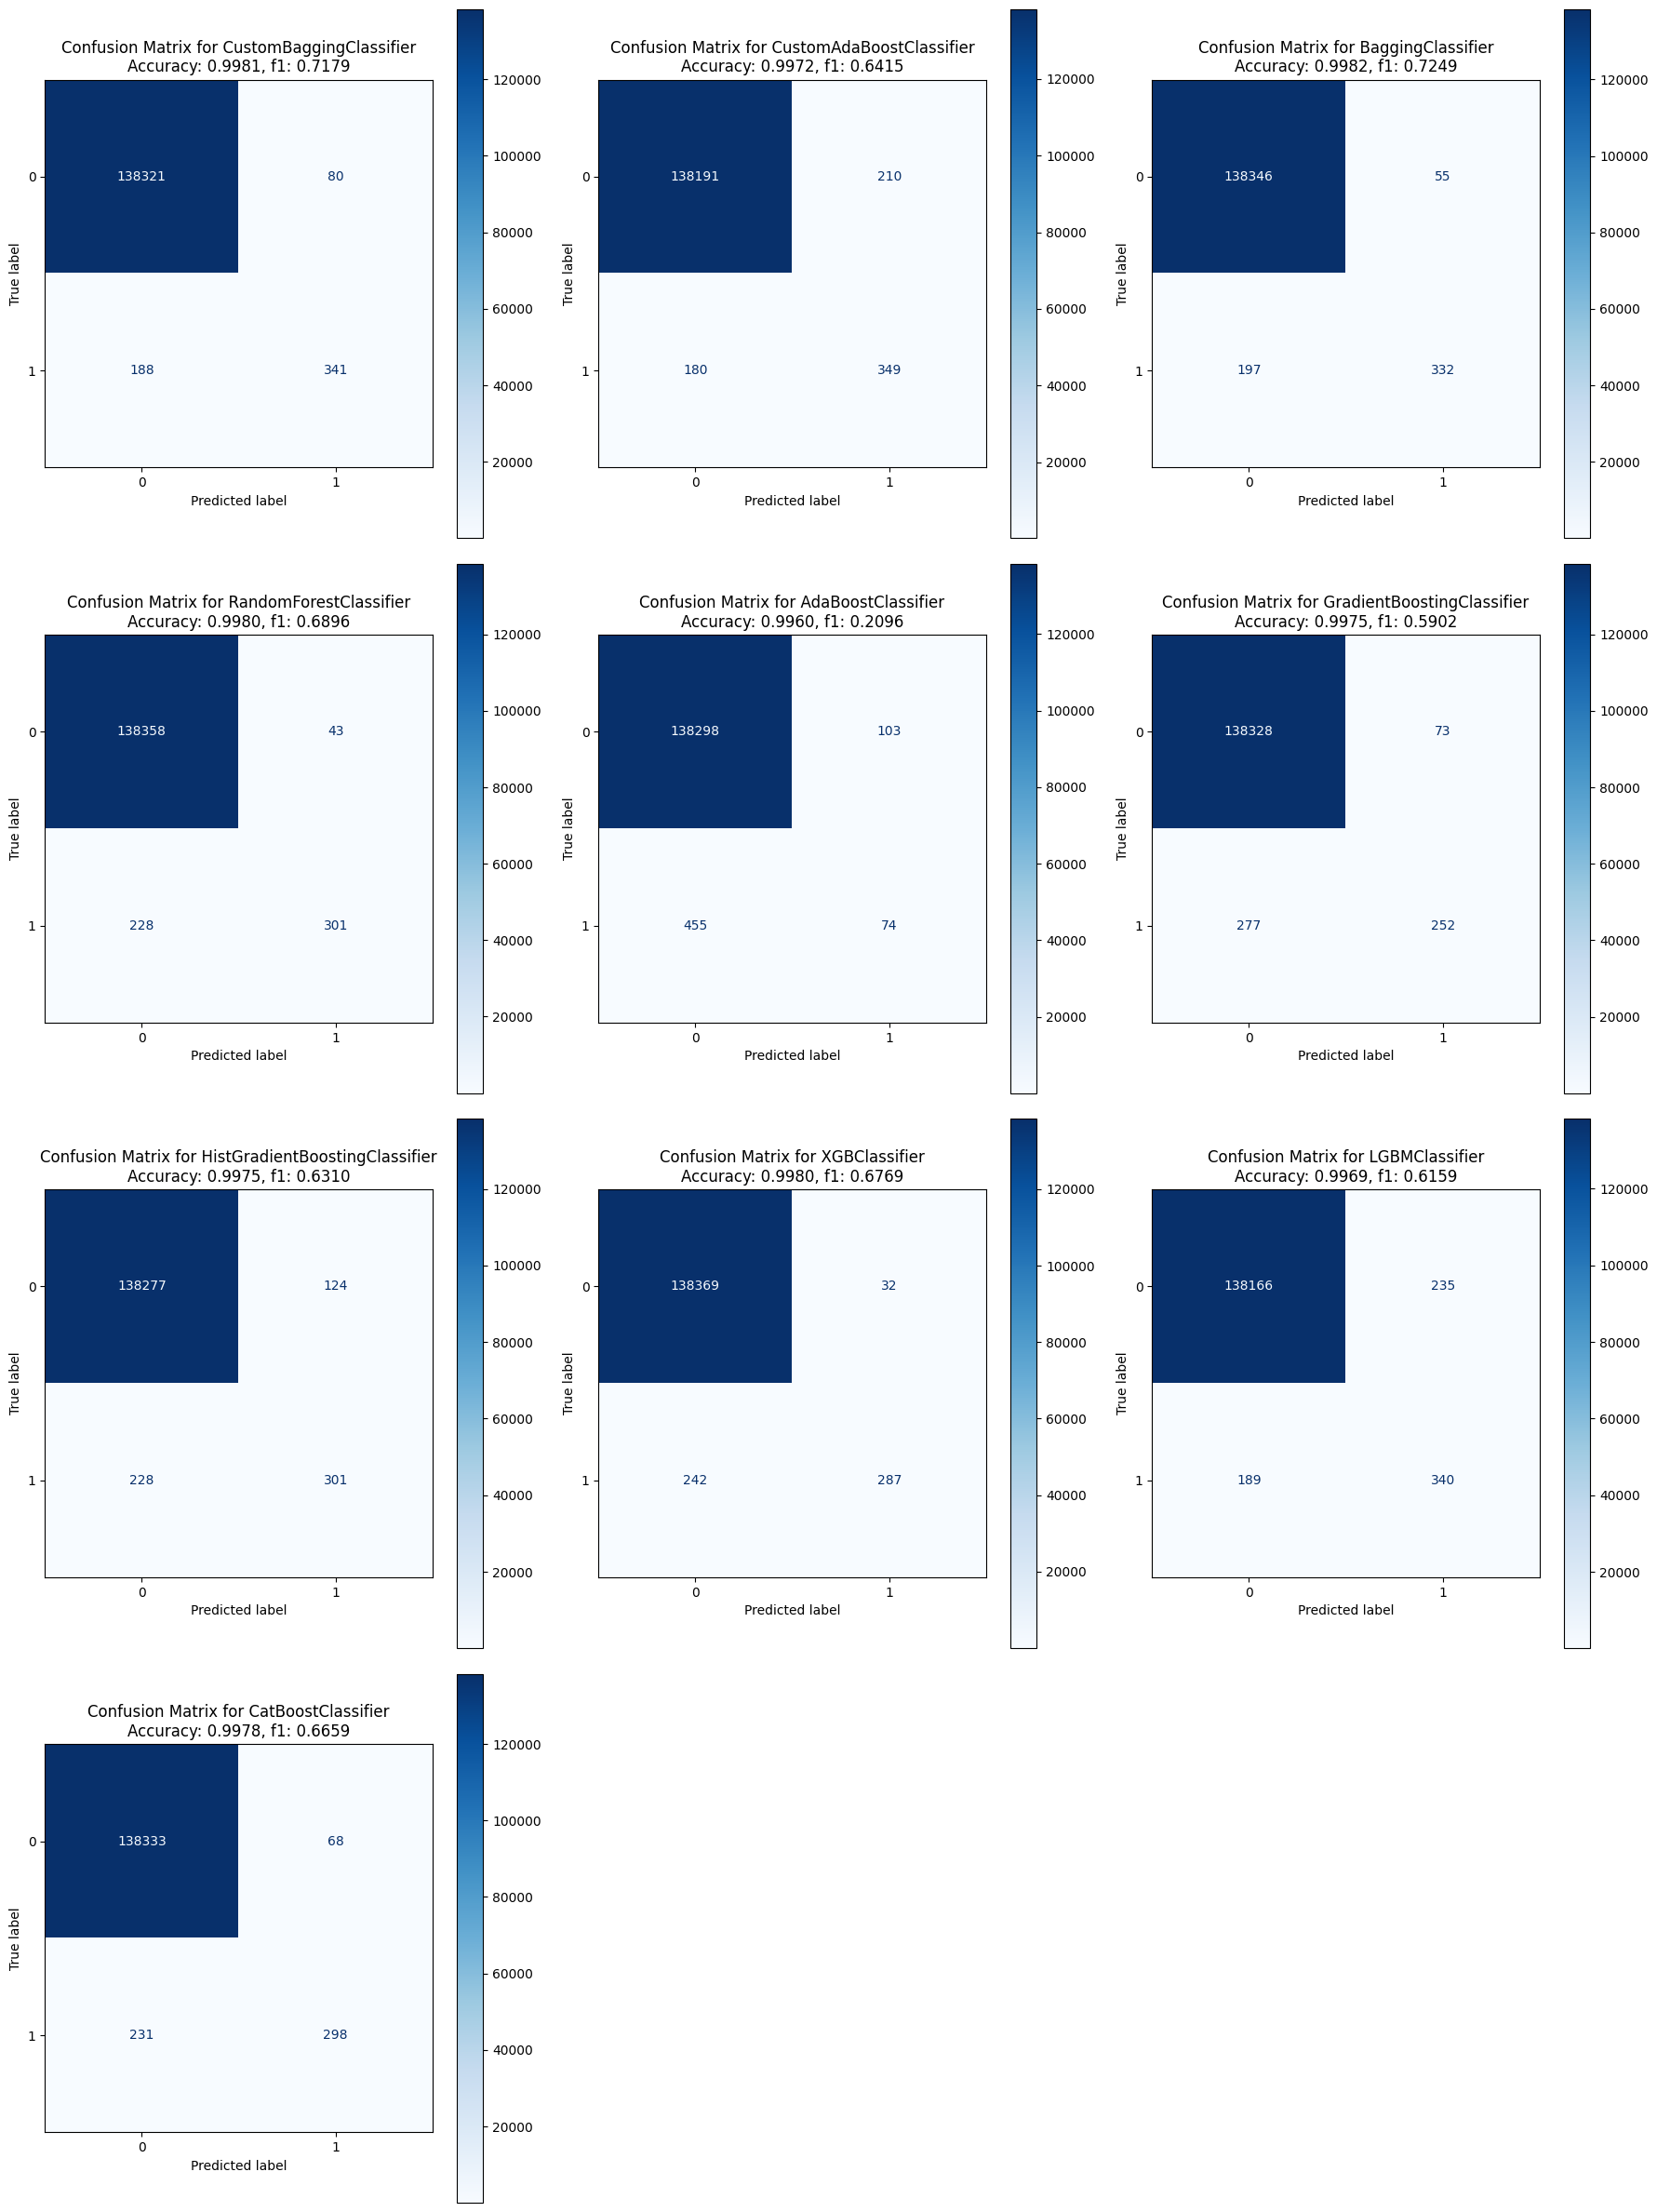

In [144]:
num_models = len(model_search_spaces.keys())
cols = 3
rows = num_models // cols + (num_models % cols > 0)

plt.figure(figsize=(cols * 6, rows * 6))

for i, model_name in enumerate(model_search_spaces.keys(), 1):
    model = create_model(model_name, best_params[model_name])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(rows, cols, i)
    plt.title(f"Confusion Matrix for {model_name}\nAccuracy: {accuracy:.4f}, f1: {f1:.4f}")
    ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d', cmap='Blues', ax=plt.gca())

plt.tight_layout()
plt.show()

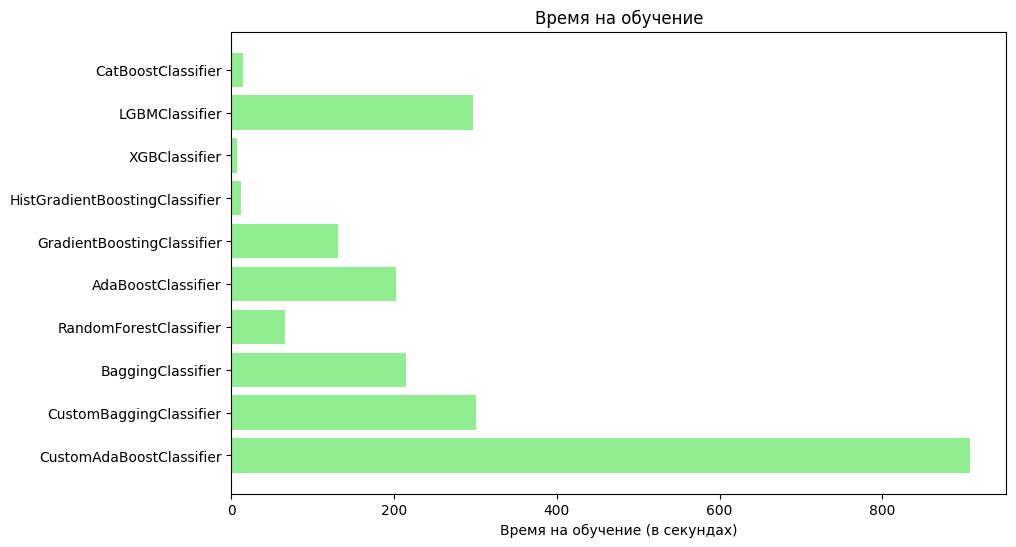

In [145]:
models = [result[0] for result in results]
training_times = [result[3] for result in results]

plt.figure(figsize=(10, 6))
plt.barh(models, training_times, color='lightgreen', label='Время на обучение (в секундах)')
plt.xlabel('Время на обучение (в секундах)')
plt.title('Время на обучение')
plt.show()

Большинство моделей работают с точностью 0.6 -- 0.7 по метрике f1. Лучшую точность показал BaggingClassifier (и CustomBaggingClassifier), худшую -- AdaBoostClassifier (f1=0.21).
При этом корреляция между временем на обучение и качеством очень низкая.